# LSTMs and derived architectures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##LSTM architecture
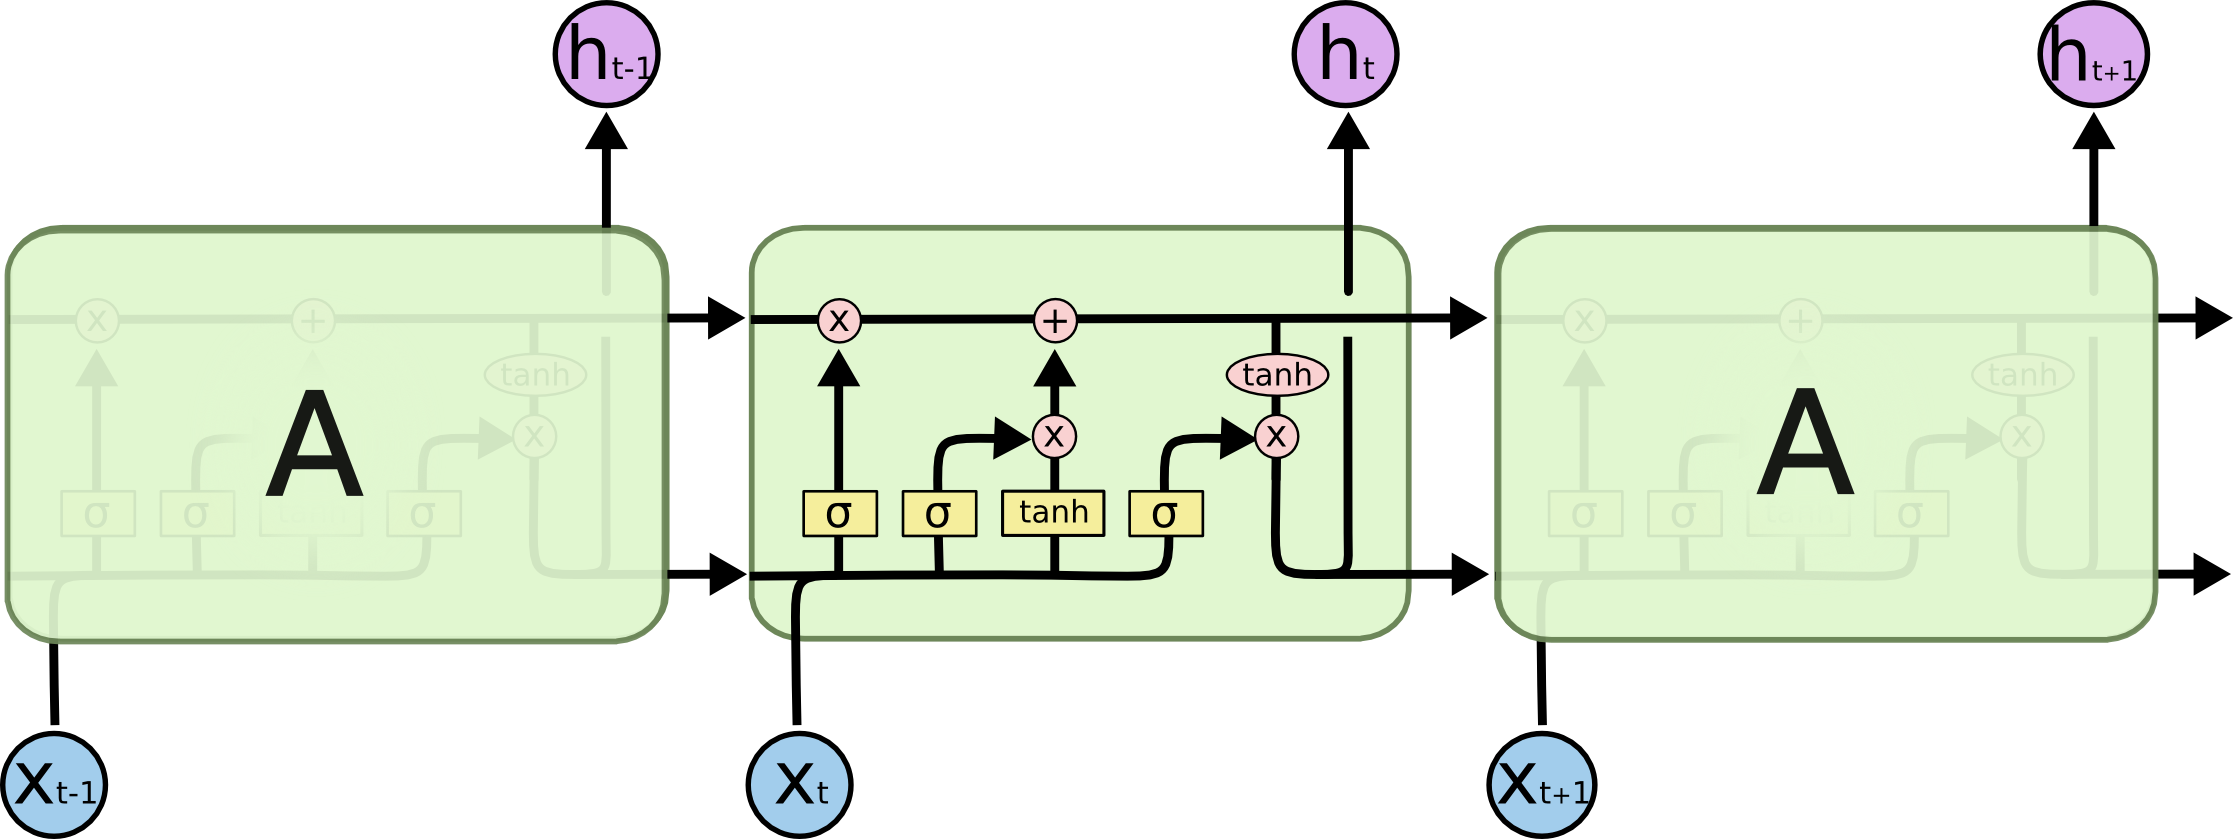

## LSTM sample network

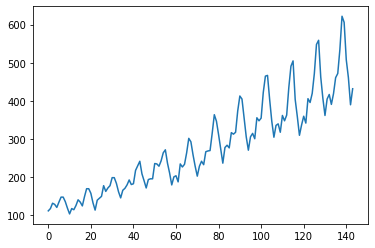

(144,)
(74, 12, 1)
(58, 12, 1)


In [7]:
# Link to Data: https://github.com/jbrownlee/Datasets/blob/master/airline-passengers.csv

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NNFL/airline-passengers.csv', usecols=[1]).values
plt.plot(dataset)
plt.show()

window_size = 12
dataset = dataset[:].reshape(-1)
max = np.max(dataset)


X_train = []
Y_train = []
X_test = []
Y_test = []


# Generating the Time Stamped Data in fixed intervals...basically look at first 'window_size' timesteps, and predict the next timestep value

for i in range(window_size, int(dataset.shape[0]*.6)):
  X_train.append(dataset[i-window_size:i])
  Y_train.append(dataset[i])


for i in range(int(dataset.shape[0]*.6), dataset.shape[0]):
  X_test.append(dataset[i-window_size:i])
  Y_test.append(dataset[i])



X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)/max

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)/max

Y_train = np.array(Y_train)/max
Y_test = np.array(Y_test)/max

print(dataset.shape)
print(X_train.shape)
print(X_test.shape)

In [ ]:
LSTM_model = tf.keras.models.Sequential()

# First dimension in input_shape to LSTM is no. of timesteps we are giving, and second dimension shows the number of features in each timestep
LSTM_model.add(tf.keras.layers.LSTM(6, input_shape=( window_size, 1)))      # 6 denotes, 6 units of LSTM
LSTM_model.add(tf.keras.layers.Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(X_train, Y_train, epochs=100, batch_size=1)

# The above created model is "many-to-one" LSTM. Adding the parameter return_sequences=True would make it "one-to-one". However, in this case using that would mean LSTM will generate 6 different outputs instead of one. Hence, we have to be careful while using that parameter about the input shapes passed to the model.

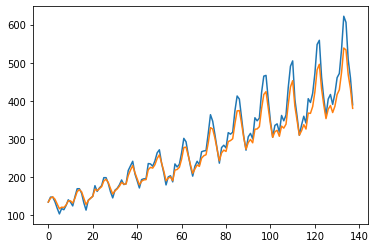

In [ ]:
Predicts = np.concatenate(( LSTM_model.predict(X_train), LSTM_model.predict(X_test) ))
Predicts *= max

plt.plot(dataset[window_size-1:-1])         # blue line   
plt.plot(Predicts)                          # orange line
plt.show()

## Bidirectional LSTMs
Sometime not just the past data but even the future data is essential to make a right prediction. For example, to predict a word in a sentence, it might be essential to know the sentence before it as well as the part of the sentence that comes after it. That's where bidirectional LSTMs come into play. *A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction.* With this form of generative deep learning, the output layer can get information from past and future states simultaneously. 


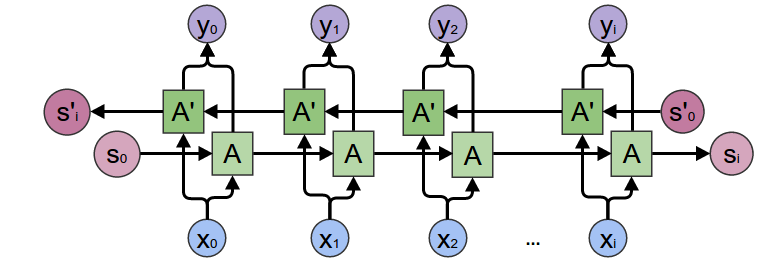

In [ ]:
max_features = 20000
maxlen = 200

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=max_features)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)  
print(x_train[0])

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences
[    5    25   100    43   838   112    50   670     2     9    35   480
   284     5   150     4   172   112   167     2   336   385    39     4
   172  4536  1111    17   546    38    13   447     4   192    50    16
     6   147  2025    19    14    22     4  1920  4613   469     4    22
    71    87    12    16    43   530    38    76    15    13  1247     4
    22    17   515    17    12    16   626    18 19193     5    62   386
    12     8   316     8   106     5     4  2223  5244    16   480    66
  3785    33     4   130    12    16    38   619     5    25   124    51
    36   135    48    25  1415    33     6    22    12   215    28    77
    52     5    14   407    16    82 10311     8     4   107   117  5952
    15   256     4     2     7  3766     5   723    36    71    43   530
   476    26   400   317    46     7     4 12118  1029    13   104    88
     4 

In [ ]:
input = tf.keras.Input(shape=(None,))
Emb = tf.keras.layers.Embedding(max_features, 128)(input)

Bi_LSTM1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(Emb)
Bi_LSTM2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(Bi_LSTM1)

output = tf.keras.layers.Dense(1, activation="sigmoid")(Bi_LSTM2)

BiLSTM_model = tf.keras.Model(input, output)
BiLSTM_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# A single LSTM layer present
BiLSTM_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
BiLSTM_model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Epoch 1/2
782/782 [==============================] - 100s 117ms/step - loss: 0.4533 - accuracy: 0.7943 - val_loss: 0.4586 - val_accuracy: 0.7865
Epoch 2/2
782/782 [==============================] - 91s 116ms/step - loss: 0.3458 - accuracy: 0.8533 - val_loss: 0.4322 - val_accuracy: 0.8052


In [ ]:
# 2 LSTM layers present - clearly, there is a boost in val accuracy, and hence it seems there might be something that another layer of LSTM can exploit.
BiLSTM_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
BiLSTM_model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Epoch 1/2
782/782 [==============================] - 205s 253ms/step - loss: 0.5082 - accuracy: 0.7534 - val_loss: 0.4408 - val_accuracy: 0.7989
Epoch 2/2
782/782 [==============================] - 196s 250ms/step - loss: 0.3601 - accuracy: 0.8470 - val_loss: 0.3860 - val_accuracy: 0.8538


## ConvLSTM
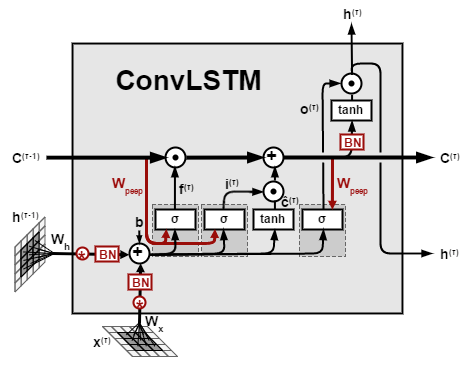

The input of a ConvLSTM is a set of images over time as a 5D tensor with shape (samples, time_steps, channels, rows, cols).

In [ ]:
# Source : https://keras.io/examples/vision/conv_lstm/

fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)
dataset = np.swapaxes(dataset, 0, 1)[:1000]
dataset = np.expand_dims(dataset, axis=-1)

819216384/819200096 [==============================] - 10s 0us/step


In [ ]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)

train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]

train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

# Shape is very important in ConvLSTM. First dimension - no. of images, second dimension - no. of frames, third dimension & fourth dimension - image shape, fifth dimension - number of channels (1 for grayscale, 3 for RGB image)

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Displaying frames for example 446.


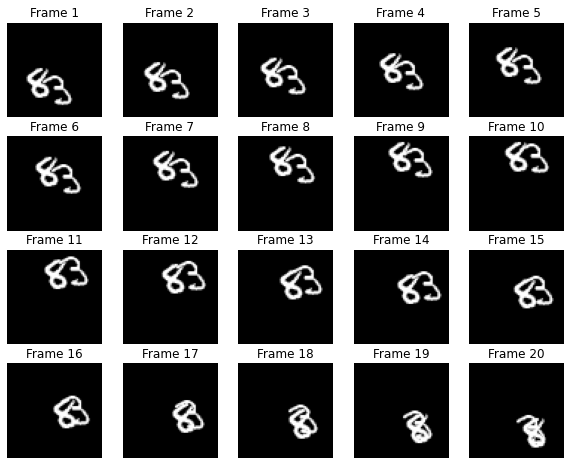

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
inp = tf.keras.layers.Input(shape=(None, *x_train.shape[2:]))


x = tf.keras.layers.ConvLSTM2D( filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(inp)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)

x = tf.keras.layers.Conv3D( filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)
model = tf.keras.models.Model(inp, x)

model.compile(
    loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(),
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
epochs = 20
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
90/90 [==============================] - 338s 3s/step - loss: 0.0808 - val_loss: 0.2478
Epoch 2/20
90/90 [==============================] - 312s 3s/step - loss: 0.0304 - val_loss: 0.2108
Epoch 3/20
90/90 [==============================] - 303s 3s/step - loss: 0.0281 - val_loss: 0.2154
Epoch 4/20
90/90 [==============================] - 303s 3s/step - loss: 0.0272 - val_loss: 0.1869
Epoch 5/20
90/90 [==============================] - 312s 3s/step - loss: 0.0266 - val_loss: 0.1325
Epoch 6/20
90/90 [==============================] - 312s 3s/step - loss: 0.0263 - val_loss: 0.0772
Epoch 7/20
90/90 [==============================] - 303s 3s/step - loss: 0.0260 - val_loss: 0.0409
Epoch 8/20
90/90 [==============================] - 301s 3s/step - loss: 0.0259 - val_loss: 0.0313
Epoch 9/20
90/90 [==============================] - 301s 3s/step - loss: 0.0258 - val_loss: 0.0257
Epoch 10/20
90/90 [==============================] - 311s 3s/step - loss: 0.0256 - val_loss: 0.0258
Epoch 11/

##Homework

Use LSTM layers and explore the window size, "Return_sequence" and what effects adding another LSTM layer will have. Understand and use the code for using simple LSTMs and try 3 models with different window sizes and use the best one from those to see how return sequences work in this example.


In [6]:
# Window size is 3
LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(6, input_shape=(3, 1)))      
LSTM_model.add(tf.keras.layers.Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(X_train, Y_train, epochs=100, batch_size=1)

Epoch 1/100
83/83 [==============================] - 2s 3ms/step - loss: 0.0637
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 6/100
83/83 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 10/100
83/83 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 11/100
83/83 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 12/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 13/100
83/83 [=================

In [4]:
# Window size is 6
LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(6, input_shape=(6, 1)))      
LSTM_model.add(tf.keras.layers.Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(X_train, Y_train, epochs=100, batch_size=1)

Epoch 1/100
80/80 [==============================] - 7s 3ms/step - loss: 0.0209
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 8/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 10/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 11/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 12/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 13/100
80/80 [=================

In [9]:
# Window size is 12
LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(6, input_shape=(12, 1)))      
LSTM_model.add(tf.keras.layers.Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(X_train, Y_train, epochs=100, batch_size=1)

Epoch 1/100
74/74 [==============================] - 2s 4ms/step - loss: 0.0611
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 4/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 5/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 6/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 7/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 8/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 9/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 10/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 11/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 12/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 13/100
74/74 [=================

Since window size of 12 worked the best among the three...further experiments (multiple LSTM layers alongside including return_sequences=True) would be done on it

In [16]:
# Window size is 12
LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(2, input_shape=(12, 1), return_sequences=True))     
LSTM_model.add(tf.keras.layers.LSTM(6, return_sequences=True))    
LSTM_model.add(tf.keras.layers.LSTM(12))      
LSTM_model.add(tf.keras.layers.Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(X_train, Y_train, epochs=100, batch_size=1)

# We need to add return_sequences=True for all LSTM layers except the last one. Setting this flag to True lets Keras know that LSTM output should contain all historical generated outputs along with time stamps (3D). So, next LSTM layer can work further on the data. If this flag is false, then LSTM only returns last output (2D). Such output is not good enough for another LSTM layer.

# NOTE: Last dense layer can be tweaked depending on the task being performed. In this case it's regression, hence it has 1 neuron. For multiclass classification between n classes, it would have n neurons, with activation function 'softmax'.

Epoch 1/100
74/74 [==============================] - 5s 9ms/step - loss: 0.0236
Epoch 2/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0066
Epoch 3/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 4/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0053
Epoch 5/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 6/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 7/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 8/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 9/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 10/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 11/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 12/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 13/100
74/74 [=================

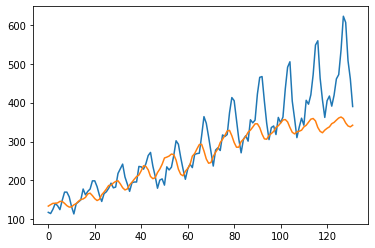

In [17]:
Predicts = np.concatenate(( LSTM_model.predict(X_train), LSTM_model.predict(X_test) ))
Predicts *= max

plt.plot(dataset[window_size-1:-1])         # blue line   
plt.plot(Predicts)                          # orange line
plt.show()